
**Install requirements**

In [0]:
#!pip3 install 'torch==1.3.1'
#!pip3 install 'torchvision==0.5.0'
#!pip3 install 'Pillow-SIMD'
#!pip3 install 'tqdm'

**Import libraries**

In [0]:
import os
import logging
import numpy as np

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Subset, DataLoader
from torch.backends import cudnn
from torchvision.datasets import VisionDataset

import torchvision
from torchvision import transforms
from torchvision.models import alexnet, resnet18, vgg16

from PIL import Image
from tqdm import tqdm

from sklearn.model_selection import StratifiedShuffleSplit
import matplotlib.pyplot as plt

FIG_SIZE = (10, 7)
RANDOM_STATE = 42

**Set Arguments**

In [0]:
DEVICE = 'cuda' # 'cuda' or 'cpu'

NUM_CLASSES = 102 # 101 + 1: There is am extra Background class that should be removed 

BATCH_SIZE = 32

# BATCH_SIZE = 128
# BATCH_SIZE = 256     # Higher batch sizes allows for larger learning rates. An empirical heuristic suggests that, when changing
                     # the batch size, learning rate should change by the same factor to have comparable results

LR = 1e-2            # The initial Learning Rate
MOMENTUM = 0.9       # Hyperparameter for SGD, keep this at 0.9 when using SGD
WEIGHT_DECAY = 5e-5  # Regularization, you can keep this at the default

NUM_EPOCHS = 30      # Total number of training epochs (iterations over dataset)
STEP_SIZE = 15       # How many epochs before decreasing learning rate (if using a step-down policy)
GAMMA = 0.1          # Multiplicative factor for learning rate step-down

LOG_FREQUENCY = 10

**Define Data Preprocessing**

In [0]:
# Define transforms for training phase
train_transform = transforms.Compose([transforms.Resize(256),      # Resizes short size of the PIL image to 256
                                      transforms.CenterCrop(224),  # Crops a central square patch of the image
                                                                   # 224 because torchvision's AlexNet needs a 224x224 input!
                                                                   # Remember this when applying different transformations, otherwise you get an error
                                      transforms.ToTensor(), # Turn PIL Image to torch.Tensor
                                      transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225)) # Normalize tensor with ImageNet’s mean and standard deviation
                                      #transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)) # Normalizes tensor with mean and standard deviation
])


# One set of preprocessing
# train_transform = transforms.Compose([transforms.Resize(256),      # Resizes short size of the PIL image to 256
#                                       transforms.CenterCrop(224),  # Crops a central square patch of the image
#                                                                    # 224 because torchvision's AlexNet needs a 224x224 input!
#                                                                    # Remember this when applying different transformations, otherwise you get an error
#                                       transforms.RandomRotation(degrees=25),
#                                       transforms.ColorJitter(),
#                                       transforms.ToTensor(), # Turn PIL Image to torch.Tensor
#                                       transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225)) # Normalize tensor with ImageNet’s mean and standard deviation
# ])

# Two set of preprocessing
# train_transform = transforms.Compose([transforms.Resize(256),      # Resizes short size of the PIL image to 256
#                                       transforms.CenterCrop(224),  # Crops a central square patch of the image
#                                                                    # 224 because torchvision's AlexNet needs a 224x224 input!
#                                                                    # Remember this when applying different transformations, otherwise you get an error
#                                       transforms.RandomPerspective(),
#                                       transforms.RandomVerticalFlip(),
#                                       transforms.ToTensor(), # Turn PIL Image to torch.Tensor
# 
# ])

# Three set of preprocessing
# train_transform = transforms.Compose([transforms.Resize(256),      # Resizes short size of the PIL image to 256
#                                       transforms.CenterCrop(224),  # Crops a central square patch of the image
#                                                                    # 224 because torchvision's AlexNet needs a 224x224 input!
#                                                                    # Remember this when applying different transformations, otherwise you get an error
#                                       transforms.RandomGrayscale(),
#                                       transforms.RandomHorizontalFlip(),
#                                       transforms.ToTensor(), # Turn PIL Image to torch.Tensor
# 
# ])


# Define transforms for the evaluation phase
eval_transform = transforms.Compose([transforms.Resize(256),
                                      transforms.CenterCrop(224),
                                      transforms.ToTensor(),
                                      transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225)) # Normalize tensor with ImageNet’s mean and standard deviation
                                      #transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))                                    
])

In [0]:
def pil_loader(path):
    # open path as file to avoid ResourceWarning (https://github.com/python-pillow/Pillow/issues/835)
    with open(path, 'rb') as f:
        img = Image.open(f)
        return img.convert('RGB')


class Caltech(VisionDataset):
    def __init__(self, root, split='train', transform=None, target_transform=None):
        super(Caltech, self).__init__(root, transform=transform, target_transform=target_transform)

        self.split = split # This defines the split you are going to use
                           # (split files are called 'train.txt' and 'test.txt')
        
        split_dir = "Caltech101/" + split + ".txt"
        split_txt = np.loadtxt(split_dir, delimiter="/", dtype=np.str)

        classes = list(set(split_txt[:,0]))
        classes.remove("BACKGROUND_Google")
        classes.sort()
        class_to_idx = {classes[i]: i for i in range(len(classes))}

        samples = []
        directory = os.path.expanduser(root)

        for target_class, fname in split_txt:
          if target_class in class_to_idx:
              class_index = class_to_idx[target_class]
              target_dir = os.path.join(directory, target_class)
              
              if not os.path.isdir(target_dir):
                  continue
              
              path = os.path.join(target_dir, fname)
              item = path, class_index
              samples.append(item)      

        self.classes = classes
        self.class_to_idx = class_to_idx
        self.samples = samples            

        '''
        - Here you should implement the logic for reading the splits files and accessing elements
        - If the RAM size allows it, it is faster to store all data in memory
        - PyTorch Dataset classes use indexes to read elements
        - You should provide a way for the __getitem__ method to access the image-label pair
          through the index
        - Labels should start from 0, so for Caltech you will have lables 0...100 (excluding the background class) 
        '''

    def __getitem__(self, index):
        '''
        __getitem__ should access an element through its index
        Args:
            index (int): Index

        Returns:
            tuple: (sample, target) where target is class_index of the target class.
        '''

        # image, label = ... # Provide a way to access image and label via index
                           # Image should be a PIL Image
                           # label can be int

        path, label = self.samples[index]
        image = pil_loader(path)

        # Applies preprocessing when accessing the image
        if self.transform is not None:
            image = self.transform(image)

        return image, label

    def __len__(self):
        '''
        The __len__ method returns the length of the dataset
        It is mandatory, as this is used by several other components
        '''
        length = len(self.samples) # Provide a way to get the length (number of elements) of the dataset
        return length


**Prepare Dataset**

In [6]:
# Clone github repository with data
if not os.path.isdir('./Caltech101'):
  !git clone https://github.com/MachineLearning2020/Homework2-Caltech101.git
  !mv 'Homework2-Caltech101' 'Caltech101'

DATA_DIR = 'Caltech101/101_ObjectCategories'

# Prepare Pytorch train/test Datasets
train_dataset = Caltech(DATA_DIR, split='train',  transform=train_transform)
test_dataset = Caltech(DATA_DIR, split='test', transform=eval_transform)

s = StratifiedShuffleSplit(n_splits=1, test_size=0.5)
train_indexes, val_indexes = next(s.split(np.asarray(train_dataset.samples)[:,0], 
                                           np.asarray(train_dataset.samples)[:,1]))

val_dataset = Subset(train_dataset, val_indexes)
train_dataset = Subset(train_dataset, train_indexes)

# Check dataset sizes
print('Train Dataset: {}'.format(len(train_dataset)))
print('Valid Dataset: {}'.format(len(val_dataset)))
print('Test Dataset: {}'.format(len(test_dataset)))

Train Dataset: 2892
Valid Dataset: 2892
Test Dataset: 2893


**Prepare Dataloaders**

In [0]:
# Dataloaders iterate over pytorch datasets and transparently provide useful functions (e.g. parallelization and shuffling)
train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=4, drop_last=True)
val_dataloader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=4)

test_dataloader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=4)

**Prepare Network**

In [0]:
# net = alexnet(pretrained=True) # Loading AlexNet model
# net = resnet18(pretrained=True) # Loading resnet model
net = vgg16(pretrained=True) # Loading resnet model

# AlexNet has 1000 output neurons, corresponding to the 1000 ImageNet's classes
# We need 101 outputs for Caltech-101

net.classifier[6] = nn.Linear(4096, NUM_CLASSES) # nn.Linear in pytorch is a fully connected layer
                                                 # The convolutional layer is nn.Conv2d
# net.fc = nn.Linear(512, NUM_CLASSES)                                    

# We just changed the last layer of AlexNet with a new fully connected layer with 101 outputs
# It is strongly suggested to study torchvision.models.alexnet source code

In [9]:
net

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

**Prepare Training**

In [0]:
# Define loss function
criterion = nn.CrossEntropyLoss() # for classification, we use Cross Entropy

# Choose parameters to optimize
# To access a different set of parameters, you have to access submodules of AlexNet
# (nn.Module objects, like AlexNet, implement the Composite Pattern)
# e.g.: parameters of the fully connected layers: net.classifier.parameters()
# e.g.: parameters of the convolutional layers: look at alexnet's source code ;) 
parameters_to_optimize = net.parameters() # In this case we optimize over all the parameters of AlexNet

# parameters_to_optimize = net.classifier.parameters() # In this case we optimize over FC layers
# parameters_to_optimize = net.features.parameters() # In this case we optimize over Conv layers

# Define optimizer
# An optimizer updates the weights based on loss
# We use SGD with momentum
optimizer = optim.SGD(parameters_to_optimize, lr=LR, momentum=MOMENTUM, weight_decay=WEIGHT_DECAY)

# Define scheduler
# A scheduler dynamically changes learning rate
# The most common schedule is the step(-down), which multiplies learning rate by gamma every STEP_SIZE epochs
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=STEP_SIZE, gamma=GAMMA)

**Train**

In [11]:
# By default, everything is loaded to cpu
net = net.to(DEVICE) # this will bring the network to GPU if DEVICE is cuda
best_net = net.state_dict()
cudnn.benchmark # Calling this optimizes runtime
 
losses_val = []
current_step = 0
# Start iterating over the epochs
for epoch in range(NUM_EPOCHS):
  print('Starting epoch {}/{}, LR = {}'.format(epoch+1, NUM_EPOCHS, scheduler.get_last_lr()))
 
  # Iterate over the dataset
  for images, labels in train_dataloader:
    # Bring data over the device of choice
    images = images.to(DEVICE)
    labels = labels.to(DEVICE)
 
    net.train() # Sets module in training mode
 
    # PyTorch, by default, accumulates gradients after each backward pass
    # We need to manually set the gradients to zero before starting a new iteration
    optimizer.zero_grad() # Zero-ing the gradients
 
    # Forward pass to the network
    outputs = net(images)
 
    # Compute loss based on output and ground truth
    loss = criterion(outputs, labels)
 
    # Log loss
    if current_step % LOG_FREQUENCY == 0:
      print('Step {}, Loss {}'.format(current_step, loss.item()))
 
    # Compute gradients for each layer and update weights
    loss.backward()  # backward pass: computes gradients
    optimizer.step() # update weights based on accumulated gradients
 
    current_step += 1
 
  # Test model on validation test
  net.train(False) # Set Network to evaluation mode
 
  running_corrects = 0
  loss_val = 0
  for images, labels in val_dataloader:
    images = images.to(DEVICE)
    labels = labels.to(DEVICE)
 
    # Forward Pass
    outputs = net(images)
 
    # Get predictions
    _, preds = torch.max(outputs.data, 1)
 
    # Compute loss based on output and ground truth
    loss_val += criterion(outputs, labels).item()
 
  # Save loss for validation
  losses_val.append(loss_val/len(val_dataloader))
 
  if min(losses_val) == loss_val:
    best_net = net.state_dict()
 
  # Step the scheduler
  scheduler.step()

Starting epoch 1/30, LR = [0.01]
Step 0, Loss 4.775665760040283
Step 10, Loss 2.7960875034332275
Step 20, Loss 2.680499792098999
Step 30, Loss 1.9004571437835693
Step 40, Loss 2.46470308303833
Step 50, Loss 2.634488105773926
Step 60, Loss 2.0292181968688965
Step 70, Loss 2.3174662590026855
Step 80, Loss 2.133976936340332
Starting epoch 2/30, LR = [0.01]
Step 90, Loss 2.048888921737671
Step 100, Loss 1.9469506740570068
Step 110, Loss 1.1477488279342651
Step 120, Loss 1.1513066291809082
Step 130, Loss 1.6770232915878296
Step 140, Loss 1.9214364290237427
Step 150, Loss 1.265116810798645
Step 160, Loss 1.0703990459442139
Step 170, Loss 0.927706241607666
Starting epoch 3/30, LR = [0.01]
Step 180, Loss 0.48454076051712036
Step 190, Loss 0.551345705986023
Step 200, Loss 0.7476148009300232
Step 210, Loss 0.8530974984169006
Step 220, Loss 0.545818030834198
Step 230, Loss 0.7330348491668701
Step 240, Loss 0.8499718904495239
Step 250, Loss 0.7952815294265747
Step 260, Loss 0.3139508068561554
Star

Text(0, 0.5, 'Loss')

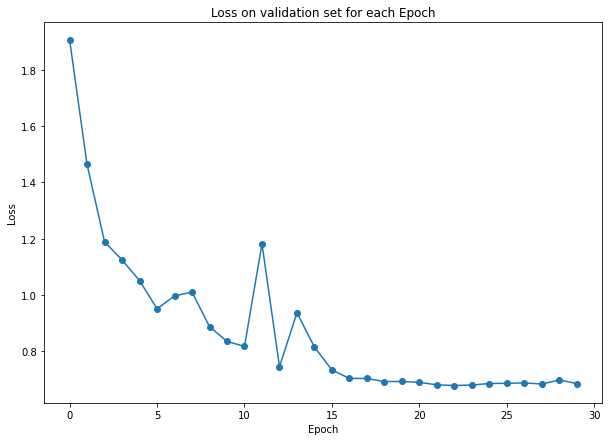

In [12]:
plt.figure(figsize=FIG_SIZE)
plt.plot(range(NUM_EPOCHS),losses_val,marker='o')

plt.title("Loss on validation set for each Epoch")
plt.xlabel("Epoch")
plt.ylabel("Loss")

**Validation**

In [13]:
net.load_state_dict(best_net)
net = net.to(DEVICE) # this will bring the network to GPU if DEVICE is cuda
net.train(False) # Set Network to evaluation mode

running_corrects = 0
for images, labels in tqdm(val_dataloader):
  images = images.to(DEVICE)
  labels = labels.to(DEVICE)

  # Forward Pass
  outputs = net(images)

  # Get predictions
  _, preds = torch.max(outputs.data, 1)

  # Update Corrects
  running_corrects += torch.sum(preds == labels.data).data.item()

# Calculate Accuracy
accuracy = running_corrects / float(len(val_dataset))

print('Validation Accuracy: {}'.format(accuracy))

100%|██████████| 91/91 [00:16<00:00,  5.59it/s]

Validation Accuracy: 0.8672199170124482


**Test**

In [14]:
net = net.to(DEVICE) # this will bring the network to GPU if DEVICE is cuda
net.train(False) # Set Network to evaluation mode

running_corrects = 0
for images, labels in tqdm(test_dataloader):
  images = images.to(DEVICE)
  labels = labels.to(DEVICE)

  # Forward Pass
  outputs = net(images)

  # Get predictions
  _, preds = torch.max(outputs.data, 1)

  # Update Corrects
  running_corrects += torch.sum(preds == labels.data).data.item()

# Calculate Accuracy
accuracy = running_corrects / float(len(test_dataset))

print('Test Accuracy: {}'.format(accuracy))

100%|██████████| 91/91 [00:16<00:00,  5.65it/s]

Test Accuracy: 0.8575872796405116
